### Chain
Review
We built a simple graph with nodes, normal edges, and conditional edges.

Goals
Now, let's build up to a simple chain that combines 4 concepts:

Using chat messages as our graph state
Using chat models in graph nodes
Binding tools to our chat model
Executing tool calls in graph nodes

In [1]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [3]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen-2.5-32b")
result=llm.invoke(messages)
result

AIMessage(content="Orcas, also known as killer whales, can be seen in various locations along the coast of the United States. However, some of the best places to see them are:\n\n1. **Puget Sound, Washington**: This area is famous for its resident orcas, particularly the Southern Resident orca population, which is known to frequent the waters between Washington State and Vancouver, British Columbia. The best times to see them are from late spring to early fall.\n\n2. **San Juan Islands, Washington**: Close to the Puget Sound, these islands offer excellent opportunities for whale watching tours. Organizations like the Whale Museum and the Center for Whale Research in Friday Harbor provide educational tours and information.\n\n3. **Seattle, Washington**: From Seattle, you can take whale watching tours that often lead to the San Juan Islands and the waters of the Puget Sound.\n\n4. **Kenai Fjords National Park, Alaska**: This area offers a different experience with orcas that are part of 

In [4]:
def add(a:int,b:int)-> int:
    """Add a and b.

    Args:
        a: first int
        b: second int
    """
    return a+b

In [5]:
llm_with_tools=llm.bind_tools([add])

In [6]:
tool_call=llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 3", name="Lance")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qxxm', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 192, 'total_tokens': 217, 'completion_time': 0.125, 'prompt_time': 0.011914488, 'queue_time': 0.054323370999999995, 'total_time': 0.136914488}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_92412bc7e4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3a3bbb40-11e0-4306-9036-a449328a2030-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': 'call_qxxm', 'type': 'tool_call'}], usage_metadata={'input_tokens': 192, 'output_tokens': 25, 'total_tokens': 217})

In [7]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 3},
  'id': 'call_qxxm',
  'type': 'tool_call'}]

In [8]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class MessageState(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [9]:
initial_message=[AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on generative ai.", name="Krish")
                   ]
# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

add_messages(initial_message,new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='4a8224d0-7807-49c3-aa14-af6d55351718'),
 HumanMessage(content="I'm looking for information on generative ai.", additional_kwargs={}, response_metadata={}, name='Krish', id='55349043-f7d5-4896-a3e8-969fa9eecced'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='294c1ce4-60b3-49ff-85a0-61566fbc0274')]

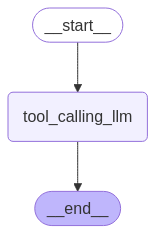

In [10]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessageState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessageState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
messages=graph.invoke({"messages":HumanMessage(content="What is 2 minus 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 minus 3
================================== Ai Message ==================================

To calculate 2 minus 3, we can think of it as adding 2 and the opposite of 3, which is -3. Thus, the operation becomes 2 + (-3). Since we only have an addition function available, we can use it by providing 2 as the first number and -3 as the second number.

However, since the question is about subtraction and our available tool only supports addition, let's directly compute the result without calling a function, as the operation is straightforward.

2 minus 3 equals -1.


In [12]:
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [13]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

### Tools
Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language.

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user.

And, it will return an output that adheres to the tool's schema.

Many LLM providers support tool calling and tool calling interface in LangChain is simple.

You can simply pass any Python function into ChatModel.bind_tools(function).

In [14]:
llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [54]:
llm_with_tools = llm.bind_tools([multiply,add])

In [55]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState




In [56]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

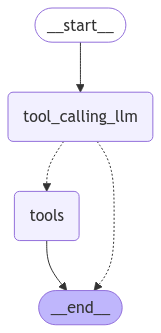

In [57]:
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply,add]))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
#builder.add_edge("tool2", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [62]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2 and add 5.")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2 and add 5.
================================== Ai Message ==================================
Tool Calls:
  add (call_eabXXmQTsnQRa5FW4b4QgP9U)
 Call ID: call_eabXXmQTsnQRa5FW4b4QgP9U
  Args:
    a: 3
    b: 4
  multiply (call_xPZ4d9WDt0sgSvGtrowA0QvJ)
 Call ID: call_xPZ4d9WDt0sgSvGtrowA0QvJ
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: add

7
================================= Tool Message =================================
Name: multiply

14
